# setup

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_rows', 100)

In [4]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

# load raw 

In [5]:
loader = csv_loader_factory('poleval')
data = loader.load()

INFO:2022-01-08 00:06:30:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-08 00:06:30:io:loaded 11039 rows


# base model

## data

In [6]:
train_df = data.loc[data['dataset']=='train', ['text_raw']]
train_label = data.loc[data['dataset']=='train', 'tag']
test_df = data.loc[data['dataset']=='test', ['text_raw']]
test_label = data.loc[data['dataset']=='test', 'tag']

{'clean_email': True,
 'clean_emoji': True,
 'clean_hashtag': True,
 'clean_non_alpha': True,
 'clean_non_letter': True,
 'clean_url': True,
 'clean_user_ref': True,
 'drop_repeated': True,
 'latinize': True,
 'to_lower': True}

In [8]:
# train
train_tokens = pd.Series(map(lambda text: text.split(), train_clean['text_clean']))
train_tokens.index = train_clean.index

train_tokens = train_tokens[(pd.Series(map(len, train_tokens))>0).values]
train_label_tok = train_label[train_tokens.index]


# test
test_tokens = pd.Series(map(lambda text: text.split(), test_clean['text_clean']))
test_tokens.index = test_clean.index

test_tokens = test_tokens[(pd.Series(map(len, test_tokens))>0).values]
test_label_tok = test_label[test_tokens.index]

In [9]:
emb = W2VEmbedder(vector_size=250, sg=1, epochs=5, max_final_vocab=5000)


emb.fit(train_tokens)
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

INFO:2022-01-08 00:06:33:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 00:06:33:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-08 00:06:33:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-08 00:06:33:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-08 00:06:33:gensim.utils:Word2Vec lifecycle event {'msg': 'max_final_vocab=5000 and min_count=5 resulted in calc_min_count=3, effective_min_count=5', 'datetime': '2022-01-08T00:06:33.719475', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-08 00:06:33:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-08 00:06:33:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min

INFO:2022-01-08 00:06:34:gensim.utils:Word2Vec lifecycle event {'msg': 'training on 525230 raw words (270631 effective words) took 0.5s, 511108 effective words/s', 'datetime': '2022-01-08T00:06:34.314890', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO:2022-01-08 00:06:34:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=250, alpha=0.025)', 'datetime': '2022-01-08T00:06:34.314890', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


## model

0:	test: 0.5092011	best: 0.5092011 (0)	total: 193ms	remaining: 3m 13s
10:	test: 0.4886679	best: 0.5128160 (1)	total: 712ms	remaining: 1m 3s
20:	test: 0.5154991	best: 0.5183634 (19)	total: 1.29s	remaining: 1m
30:	test: 0.5351091	best: 0.5380166 (29)	total: 1.79s	remaining: 55.9s
40:	test: 0.5396644	best: 0.5468424 (32)	total: 2.33s	remaining: 54.5s
50:	test: 0.5279570	best: 0.5468424 (32)	total: 2.9s	remaining: 54s
60:	test: 0.5146407	best: 0.5468424 (32)	total: 3.58s	remaining: 55.2s
70:	test: 0.5063756	best: 0.5468424 (32)	total: 4.3s	remaining: 56.3s
80:	test: 0.5105168	best: 0.5468424 (32)	total: 4.94s	remaining: 56.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5468423777
bestIteration = 32

Shrink model to first 33 iterations.


,train,test
AUC,0.615821,0.546842
Accuracy,0.836425,0.818819
F1,0.034158,0.117073
Precision,0.034158,0.169014
Recall,0.034158,0.089552


|mean pred |0.337779|0.337803|


<AxesSubplot:ylabel='Frequency'>

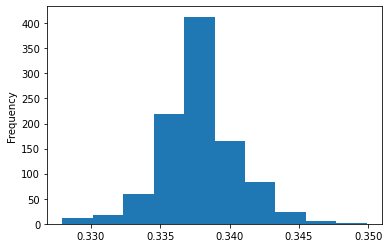

In [10]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 10,
    'grow_policy': 'Depthwise', #'SymmetricTree', 'Depthwise', 'Lossguide'
    'min_data_in_leaf': 10,
    'learning_rate': 0.01,
    'reg_lambda': 5
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# optuna

## prep data

In [ ]:
def tokenize(texts_clean: pd.Series, labels: pd.Series):
    
    tokens = pd.Series(map(lambda text: text.split(), texts_clean))
    tokens.index = texts_clean.index

    tokens = tokens[(pd.Series(map(len, tokens))>0).values]
    labels_tok = labels[tokens.index]
    
    return tokens, labels_tok
    

In [31]:
class PicklingCallback:
    def __init__(self, suffix: str):
        self.path = './opt_studies/test_study_' + suffix + '.pkl'

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        with open(self.path, 'wb') as p:
            pickle.dump(study, p)

In [25]:
import optuna

def objective(trial):
    # clean
    cleaner_params = {
        'latinize': trial.suggest_categorical('latinize', [False, True]),
        'to_lower': trial.suggest_categorical('to_lower', [False, True]),
    }
    cleaner = TextCleaner(**cleaner_params)
    train_clean = cleaner.fit_transform(train_df['text_raw'])
    test_clean = cleaner.transform(test_df['text_raw'])
    
    # tokenize
    train_tokens, train_labels_tok = tokenize(train_clean, train_label)
    test_tokens, test_labels_tok = tokenize(test_clean, test_label)
    
    # vectorize
    emb_params = {
        'vector_size': trial.suggest_int('vector_size', 50, 1000, 50),
        'sg': trial.suggest_categorical('sg', [0, 1]),
        'max_final_vocab': trial.suggest_int('max_final_vocab', 500, 20000, 100),
        'min_count': trial.suggest_int('min_count', 5, 200, 5),
        'ns_exponent': trial.suggest_discrete_uniform("ns_exponent", -0.5, 1.0, 0.05),
        'alpha': trial.suggest_discrete_uniform("alpha", 0.001, 0.101, 0.005),
        'epochs': trial.suggest_int('epochs', 3, 10, 1),        
        'workers': 16,
    }
    emb = W2VEmbedder(**emb_params)
    emb.fit(train_tokens)
    
    train_w2v = emb.transform(train_tokens)
    test_w2v = emb.transform(test_tokens)
    
    # fit model
    cb_params = {
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 101, 10),
        'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.001, 0.101, 0.005),
        'reg_lambda': trial.suggest_int('reg_lambda', 1, 9, 2),
        'max_depth': trial.suggest_int('max_depth', 2, 16, 1),
        'num_leaves': trial.suggest_int('num_leaves', 6, 36, 6),
    }

    cb = CatBoostClassifier(**cb_params)
    cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

    # eval model
    proba_train = cb.predict_proba(train_w2v)[:, 1]
    proba_test = cb.predict_proba(test_w2v)[:, 1]
    
    tresh = np.quantile(proba_train, np.mean(train_label_tok))
    pred_test = (proba_test<tresh).astype(int)
    
    auc = roc_auc_score(test_label_tok, proba_test)
    f1 = f1_score(test_label_tok, pred_test)
    
    return auc, f1


suffix = datetime.now().strftime("%Y%m%d_%H%M")
pkl_cb = PicklingCallback(suffix)

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=500, n_jobs=-1, catch=(Exception,), callbacks=[pkl_cb])


[I 2022-01-08 01:00:29,633] A new study created in memory with name: no-name-66ae00ad-ffbb-49d3-9e4a-216861c81758
INFO:2022-01-08 01:00:30:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 01:00:30:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-08 01:00:31:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 25170 word types
INFO:2022-01-08 01:00:31:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 01:00:31:gensim.models.word2vec:collected 25205 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-08 01:00:31:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 01:00:32:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-08 01:00:32:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle e

INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=70 retains 142 unique words (0.6236549694760419%% of original 22769, drops 22627)', 'datetime': '2022-01-08T01:00:32.535527', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=155 retains 59 unique words (0.27108987318507627%% of original 21764, drops 21705)', 'datetime': '2022-01-08T01:00:32.543537', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=130 leaves 39667 word corpus (37.761552081945055%% of original 105046, drops 65379)', 'datetime': '2022-01-08T01:00

INFO:2022-01-08 01:00:32:gensim.models.word2vec:estimated required memory for 70 words and 400 dimensions: 259000 bytes
INFO:2022-01-08 01:00:32:gensim.models.word2vec:sample=0.001 downsamples 64 most-common words
INFO:2022-01-08 01:00:32:gensim.models.word2vec:sample=0.001 downsamples 79 most-common words
INFO:2022-01-08 01:00:32:gensim.models.word2vec:sample=0.001 downsamples 67 most-common words
INFO:2022-01-08 01:00:32:gensim.models.word2vec:sample=0.001 downsamples 53 most-common words
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 16 workers on 2573 vocabulary and 250 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2022-01-08T01:00:32.657226', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO:2022-01-08 01:00:32:gensim.models.word2vec:estimated required memory for 142

INFO:2022-01-08 01:00:32:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 16 workers on 327 vocabulary and 850 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2022-01-08T01:00:32.803661', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO:2022-01-08 01:00:32:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:2022-01-08 01:00:32:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:32:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 16 workers on 53 vocabulary and 950 features, using sg=1 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2022-01-08T01:00:32.831587', 'gensi

INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2ve

INFO:2022-01-08 01:00:33:gensim.models.word2vec:EPOCH - 1 : training on 105046 raw words (27868 effective words) took 0.4s, 76683 effective words/s
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:EPOCH - 1 : training on 105046 raw words (8821 effective words) took 0.3s, 27239 effective words/s
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread fi

INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:EPOCH - 2 : training on 105046 raw words (30658 effective words) took 0.4s, 87401 effective words/s
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO

INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:33:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:33:gensim.models.

INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:EPOCH - 3 : training on 105046 raw words (30683 effective words) took 0.5s, 65101 effective words/s
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INF

INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:34:gensim.models.

INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2

INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:2022-01-08 01:00:34:gensim.models.word2vec:EPOCH - 5 : training on 105046 raw words (52604 effective words) took 0.4s, 136726 effective words/s


INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:35:gensim.models.wo

INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:EPOCH - 6 : training on 105046 raw words (30702 effective words) took 0.4s, 71911 effective words/s
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INF

INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:2022-01-08 01:00:35:gensim.models.w

INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:35:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:35:gensim.models.wo

INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:EPOCH - 8 : training on 105046 raw words (12132 effective words) took 0.3s, 42155 effective words/s
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:EPOCH - 8 : training on 105046 raw words (19574 effective wo

INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:EPOCH - 9 : training on 105046 raw words (10441 effective words) took 0.3s, 37165 effective words/s
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:2022-01-08 01:00:36:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:2022-01-08 01:00:36:gensim.utils:Word2Vec lifecycle event {'msg': 'training on 945414 raw words (94668 effective words) took 3.7s, 25805 effective words/s', 'datetime': '2022-01-08T01:00:36.443825', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'plat

[W 2022-01-08 01:00:49,047] Trial 1 failed because of the following error: CatBoostError('C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/catboost_options.cpp:950: max_leaves option works only with lossguide tree growing')
Traceback (most recent call last):
  File "c:\users\micha\desktop\proj\gensim\venv\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\micha\AppData\Local\Temp/ipykernel_12004/1054408866.py", line 48, in objective
    cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))
  File "c:\users\micha\desktop\proj\gensim\venv\lib\site-packages\catboost\core.py", line 4717, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\users\micha\desktop\proj\gensim\venv\lib\site-packages\catboost\core.py", line 2021, in _fit
    train_params =

KeyboardInterrupt: 

In [33]:


import sys

sys.path

['C:\\Users\\micha\\Desktop\\proj\\gensim',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\git\\ext\\gitdb',
 'C:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python38\\python38.zip',
 'C:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python38\\DLLs',
 'C:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python38\\lib',
 'C:\\Users\\micha\\AppData\\Local\\Programs\\Python\\Python38',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv',
 '',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\win32',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\win32\\lib',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\Pythonwin',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\micha\\.ipython',
 'c:\\users\\micha\\desktop\\proj\\gensim\\venv\\lib\\site-packages\\gitdb\\ext\\smmap']

# optuna res

In [11]:
name = 'test_study_20220108_0147.pkl'
path = os.path.join('./opt_studies/', name)

with open(path, 'rb') as p:
    study = pickle.load(p)

study_df = study.trials_dataframe()

run = len(study_df)
completed = len(study_df[study_df['state']=='COMPLETE'])

print(f'run: {run}, compleated: {completed} ({round(completed/run, 3)})')
study_df[study_df['state']=='COMPLETE'].sort_values('values_0', ascending=False)

run: 77, compleated: 16 (0.208)


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_alpha,params_epochs,params_grow_policy,params_latinize,...,params_min_count,params_min_data_in_leaf,params_ns_exponent,params_num_leaves,params_reg_lambda,params_sg,params_to_lower,params_vector_size,system_attrs_nsga2:generation,state
41,41,0.579881,0.059701,2022-01-08 01:50:06.163053,2022-01-08 01:51:12.398220,0 days 00:01:06.235167,0.046,8,Lossguide,False,...,40,41.0,0.90,12.0,1.0,0,False,1000,0,COMPLETE
1,1,0.577901,0.089552,2022-01-08 01:47:34.965274,2022-01-08 01:48:56.167559,0 days 00:01:21.202285,0.061,7,Lossguide,False,...,50,81.0,-0.35,18.0,1.0,0,False,950,0,COMPLETE
50,50,0.561725,0.052632,2022-01-08 01:50:46.561095,2022-01-08 01:51:45.400950,0 days 00:00:58.839855,0.051,7,Lossguide,False,...,115,81.0,-0.40,30.0,7.0,0,True,950,0,COMPLETE
37,37,0.559706,0.051282,2022-01-08 01:49:47.619104,2022-01-08 01:50:57.753308,0 days 00:01:10.134204,0.066,8,Lossguide,False,...,70,41.0,0.00,6.0,9.0,0,False,900,0,COMPLETE
55,55,0.559503,0.036585,2022-01-08 01:51:13.269496,2022-01-08 01:52:03.578069,0 days 00:00:50.308573,0.061,6,Lossguide,True,...,15,11.0,0.75,36.0,7.0,1,True,650,0,COMPLETE
38,38,0.558442,0.054645,2022-01-08 01:49:55.330628,2022-01-08 01:51:05.492950,0 days 00:01:10.162322,0.071,3,Lossguide,True,...,125,31.0,-0.40,24.0,3.0,0,True,550,0,COMPLETE
27,27,0.550768,0.067633,2022-01-08 01:49:14.752297,2022-01-08 01:49:47.414733,0 days 00:00:32.662436,0.081,5,Lossguide,False,...,190,91.0,0.30,6.0,3.0,0,False,450,0,COMPLETE
57,57,0.548292,0.056818,2022-01-08 01:51:17.069482,2022-01-08 01:52:20.483703,0 days 00:01:03.414221,0.101,6,Lossguide,False,...,170,81.0,0.00,24.0,7.0,1,False,700,0,COMPLETE
40,40,0.539522,0.000000,2022-01-08 01:50:01.568035,2022-01-08 01:50:12.311087,0 days 00:00:10.743052,0.021,4,Lossguide,False,...,10,51.0,0.60,30.0,3.0,0,True,350,0,COMPLETE
12,12,0.537382,0.048309,2022-01-08 01:48:12.189923,2022-01-08 01:48:48.403674,0 days 00:00:36.213751,0.051,5,Lossguide,False,...,80,81.0,0.25,36.0,5.0,0,True,600,0,COMPLETE
